###LIBRARIES

In [ ]:
pip install pyspark


In [23]:

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("XYZ Bank Deposit Classification") \
    .getOrCreate()

In [24]:
from pyspark.sql.functions import col, when
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession
import seaborn as sns
from pyspark.sql.functions import col, when
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Add this line to import Seaborn
from pyspark.sql.types import StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# Data Load

In [3]:
file_path = "/Users/tharunponnaganti/Downloads/XYZ_Bank_Deposit_Data_Classification.csv"  # Replace with your file path

# Read the CSV file into a DataFrame
data = spark.read.csv(file_path, header=True, inferSchema=True, sep=";")
data.head(5)  # Show first 5 rows to verify data is loaded correctly

[Row(age=56, job='housemaid', marital='married', education='basic.4y', default='no', housing='no', loan='no', contact='telephone', month='may', day_of_week='mon', duration=261, campaign=1, pdays=999, previous=0, poutcome='nonexistent', emp.var.rate=1.1, cons.price.idx=93.994, cons.conf.idx=-36.4, euribor3m=4.857, nr.employed=5191.0, y='no'),
 Row(age=57, job='services', marital='married', education='high.school', default='unknown', housing='no', loan='no', contact='telephone', month='may', day_of_week='mon', duration=149, campaign=1, pdays=999, previous=0, poutcome='nonexistent', emp.var.rate=1.1, cons.price.idx=93.994, cons.conf.idx=-36.4, euribor3m=4.857, nr.employed=5191.0, y='no'),
 Row(age=37, job='services', marital='married', education='high.school', default='no', housing='yes', loan='no', contact='telephone', month='may', day_of_week='mon', duration=226, campaign=1, pdays=999, previous=0, poutcome='nonexistent', emp.var.rate=1.1, cons.price.idx=93.994, cons.conf.idx=-36.4, euri

In [4]:
data = data.toDF(*[col.replace('.', '_').replace(' ', '_') for col in data.columns])
data.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57|   services| married|        high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.

# EDA

In [5]:
# Assuming you want to get summary statistics for the 'data' DataFrame
df_summary_transposed = data.summary().select(
    'summary',
    *[col(column).cast('string').alias(column) for column in data.columns[1:]]
).toPandas().transpose()

# Display the transposed summary dataframe
print(df_summary_transposed)

23/11/29 23:12:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


                    0                    1                    2         3  \
summary         count                 mean               stddev       min   
job             41188                 None                 None    admin.   
marital         41188                 None                 None  divorced   
education       41188                 None                 None  basic.4y   
default         41188                 None                 None        no   
housing         41188                 None                 None        no   
loan            41188                 None                 None        no   
contact         41188                 None                 None  cellular   
month           41188                 None                 None       apr   
day_of_week     41188                 None                 None       fri   
duration        41188    258.2850101971448   259.27924883646455         0   
campaign        41188    2.567592502670681    2.770013542902331         1   

23/11/29 23:12:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [6]:
# Basic Descriptive Statistics
data.describe().show()

# Check for Missing Values
from pyspark.sql.functions import col, count
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()


+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+-----------------+-----------------+-------------------+--------+-------------------+------------------+-------------------+------------------+-----------------+-----+
|summary|               age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|          duration|         campaign|            pdays|           previous|poutcome|       emp_var_rate|    cons_price_idx|      cons_conf_idx|         euribor3m|      nr_employed|    y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+-----------------+-----------------+-------------------+--------+-------------------+------------------+-------------------+------------------+-----------------+-----+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|    41188|41188|      41188|             41188|

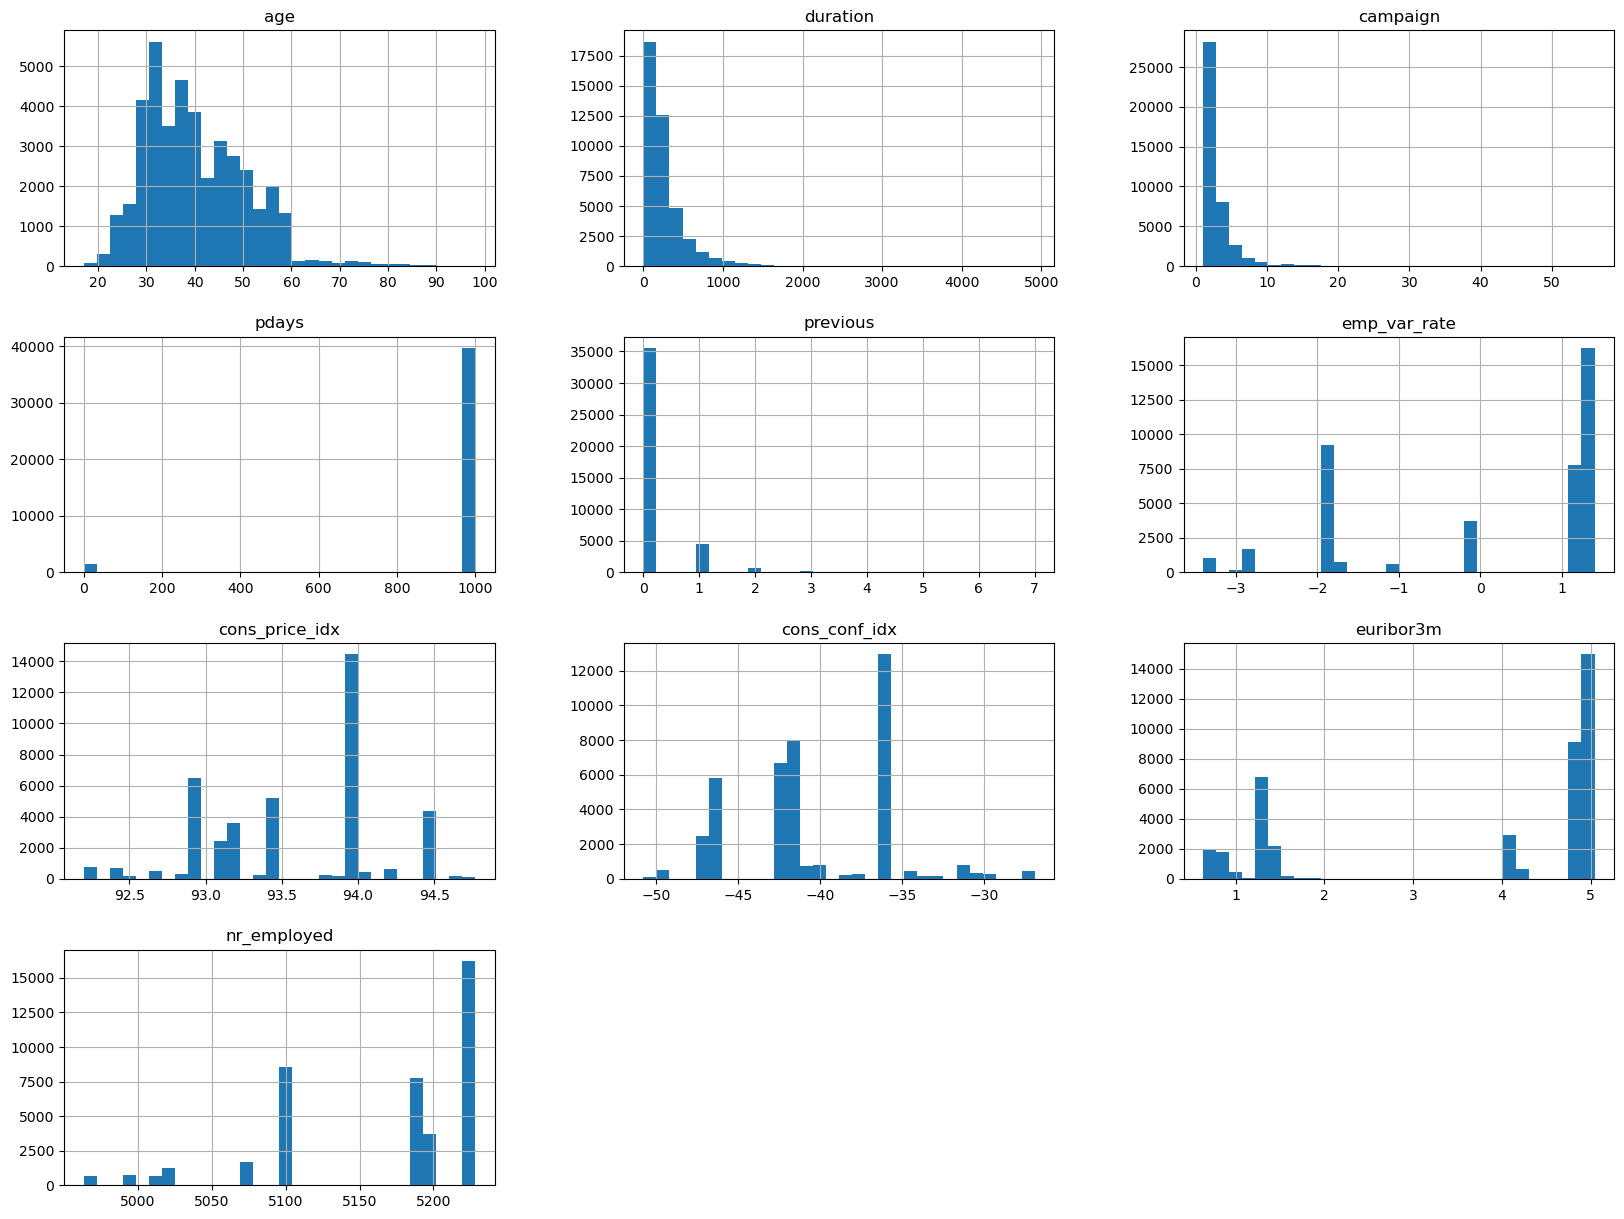

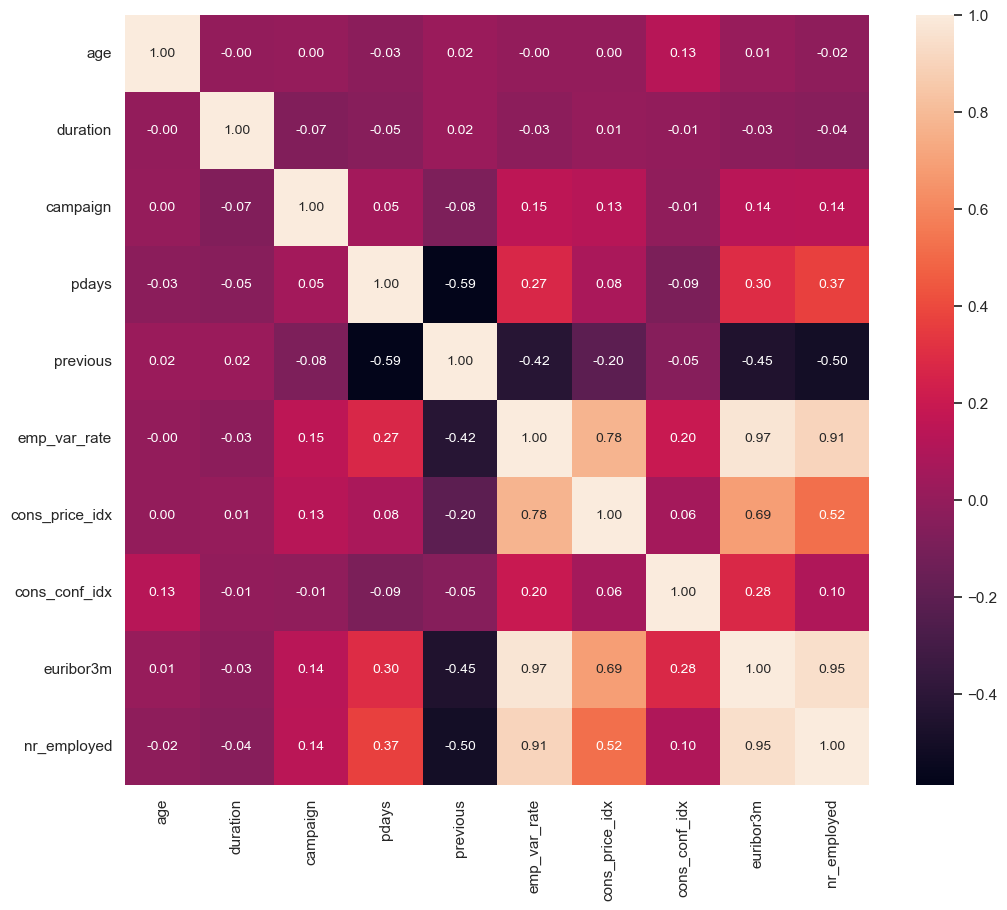

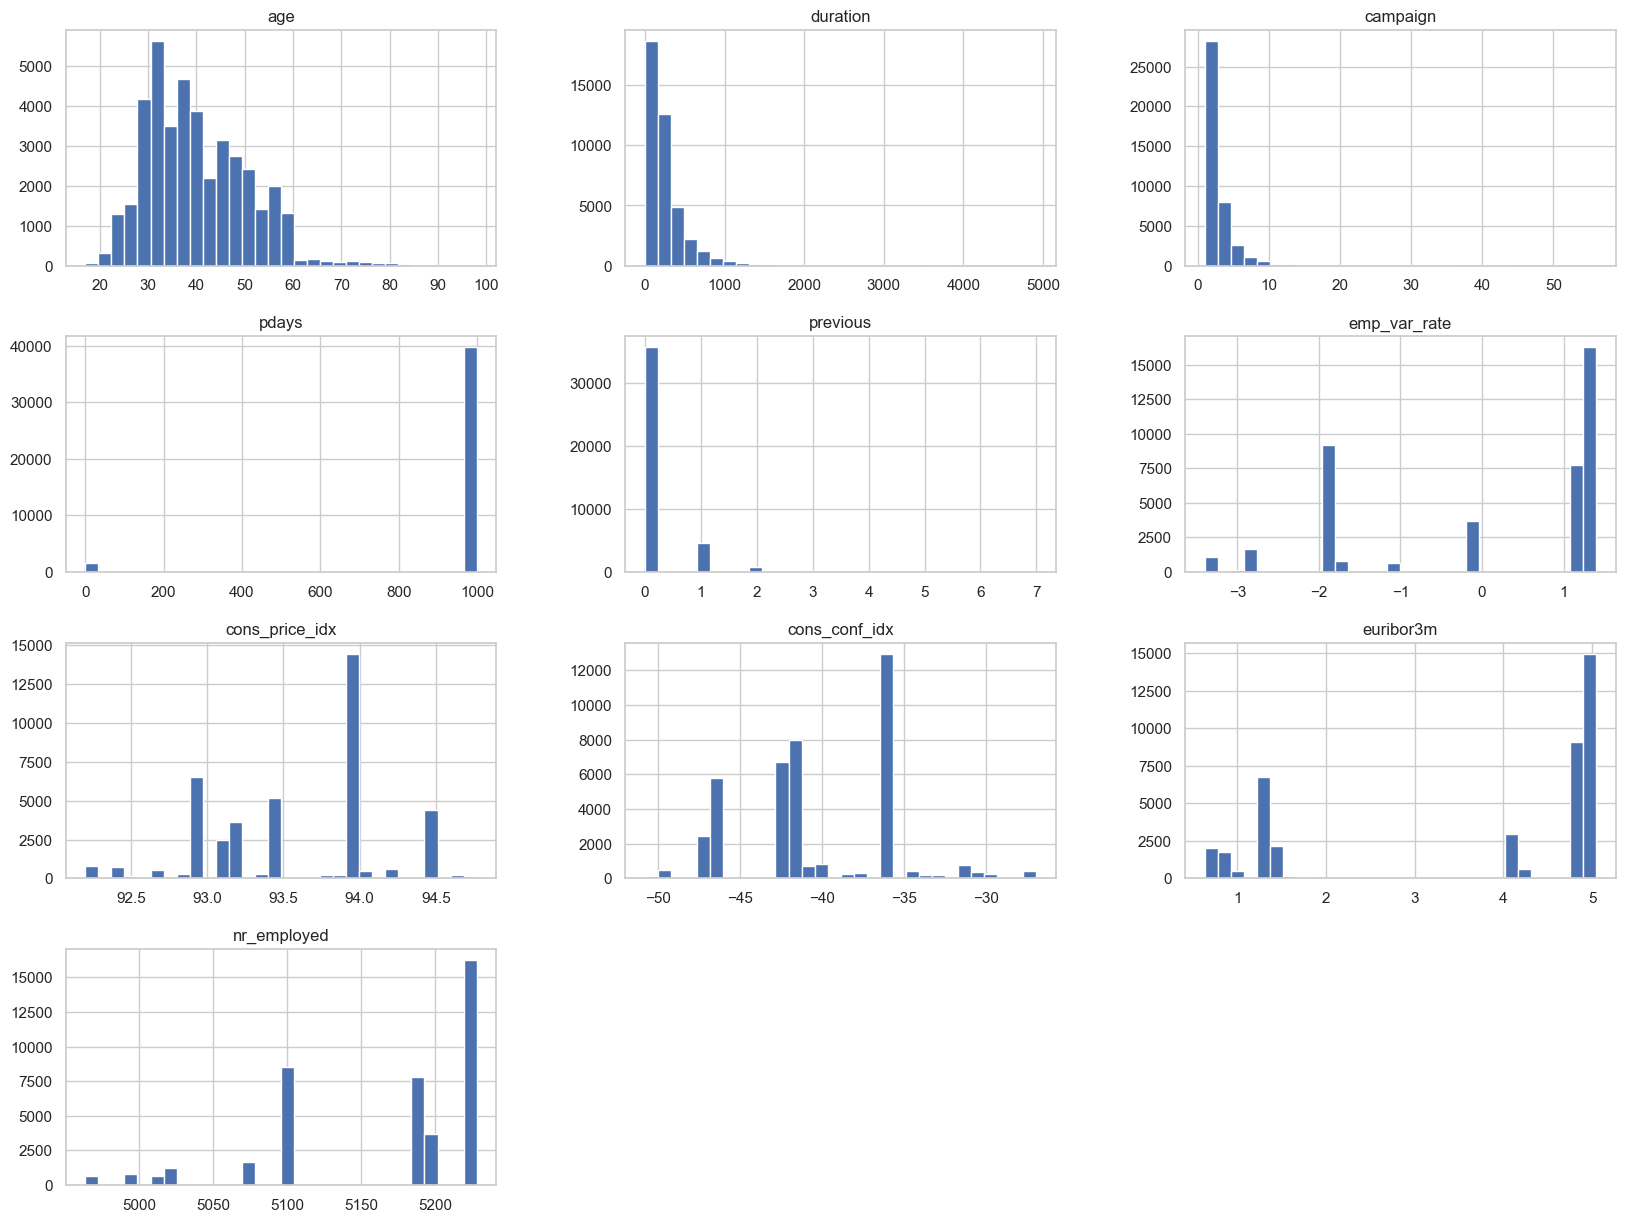

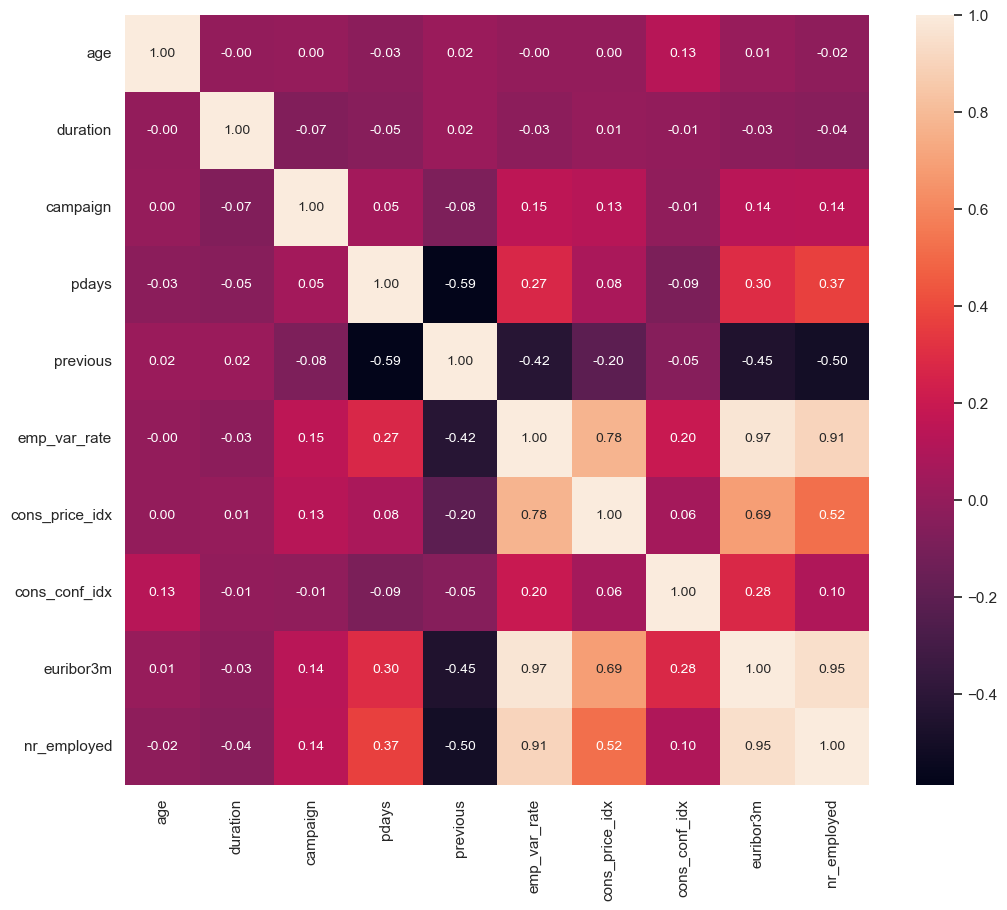

In [7]:
###EDA

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("XYZ Bank Deposit Classification") \
    .getOrCreate()



# Filter only numerical columns for histogram
numerical_columns = [col for col, dtype in data.dtypes if 'int' in dtype or 'double' in dtype]
target_column = 'y'

# Collect numerical data to the driver for plotting
numerical_data = data.select(numerical_columns).toPandas()

# Histogram for numerical columns
numerical_data.hist(bins=30, figsize=(20, 15))
plt.show()

# Correlation heatmap for numerical features only
if len(numerical_columns) > 1:
    plt.figure(figsize=(12, 10))
    sns.set(style="whitegrid")
    plt.xticks(rotation=45)
    sns.heatmap(numerical_data.corr(), annot=True, fmt=".2f", annot_kws={"size": 10})
    plt.show()


# Filter only numerical columns for histogram
numerical_columns = [col for col, dtype in data.dtypes if 'int' in dtype or 'double' in dtype]

# Collect numerical data to the driver for plotting
numerical_data = data.select(numerical_columns).toPandas()

# Histogram for numerical columns
numerical_data.hist(bins=30, figsize=(20, 15))
plt.show()

# Correlation heatmap for numerical features only
if len(numerical_columns) > 1:
    plt.figure(figsize=(12, 10))
    sns.set(style="whitegrid")
    plt.xticks(rotation=45)
    sns.heatmap(numerical_data.corr(), annot=True, fmt=".2f", annot_kws={"size": 10})
    plt.show()



# Cardinality

In [8]:

from pyspark.sql.functions import col, countDistinct

# Calculate cardinality for each column
cardinality_data = data.agg(*[countDistinct(col(c)).alias(c) for c in data.columns])

# Collect cardinality data to the driver for displaying
cardinality_data_pd = cardinality_data.toPandas()

# Display cardinality information
print("Cardinality of each column:")
print(cardinality_data_pd)


Cardinality of each column:
   age  job  marital  education  default  housing  loan  contact  month  \
0   78   12        4          8        3        3     3        2     10   

   day_of_week  ...  campaign  pdays  previous  poutcome  emp_var_rate  \
0            5  ...        42     27         8         3            10   

   cons_price_idx  cons_conf_idx  euribor3m  nr_employed  y  
0              26             26        316           11  2  

[1 rows x 21 columns]


# Bivariate analysis

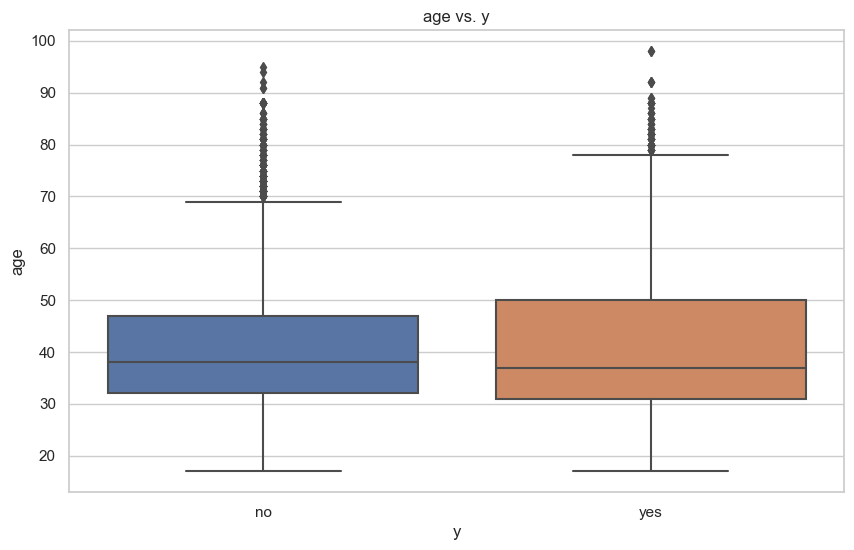

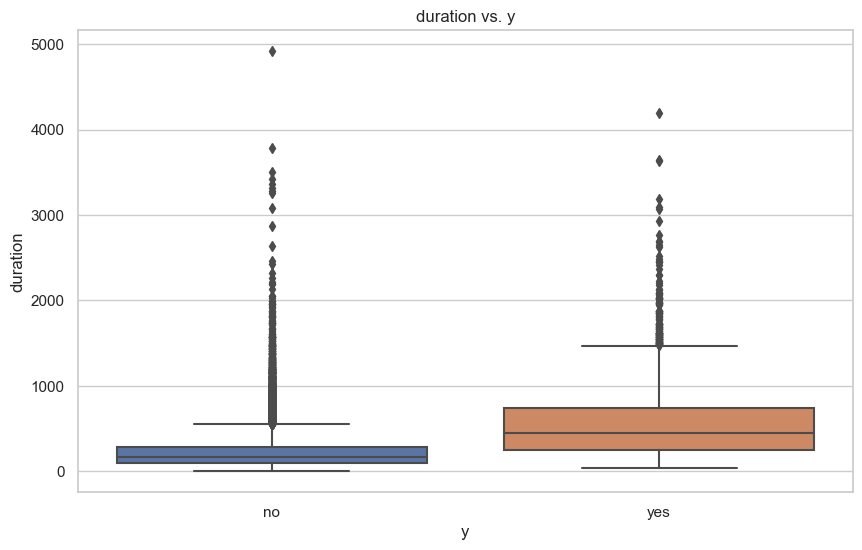

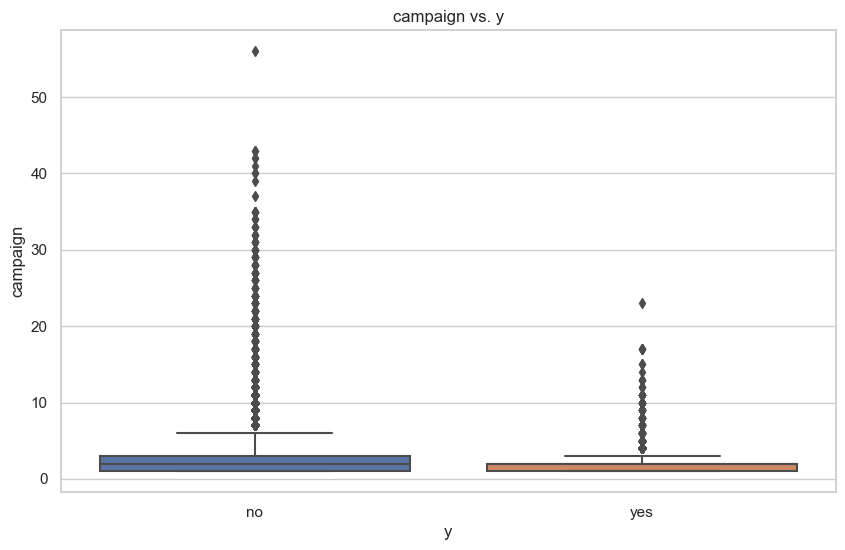

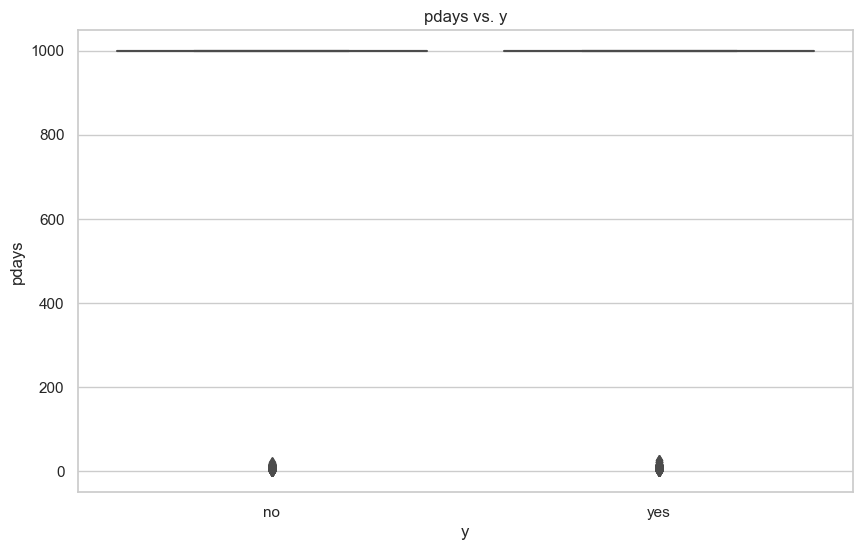

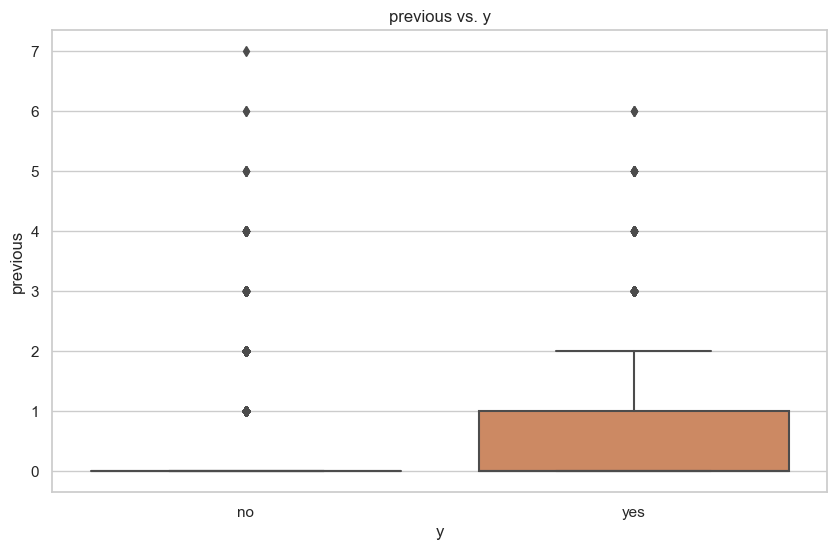

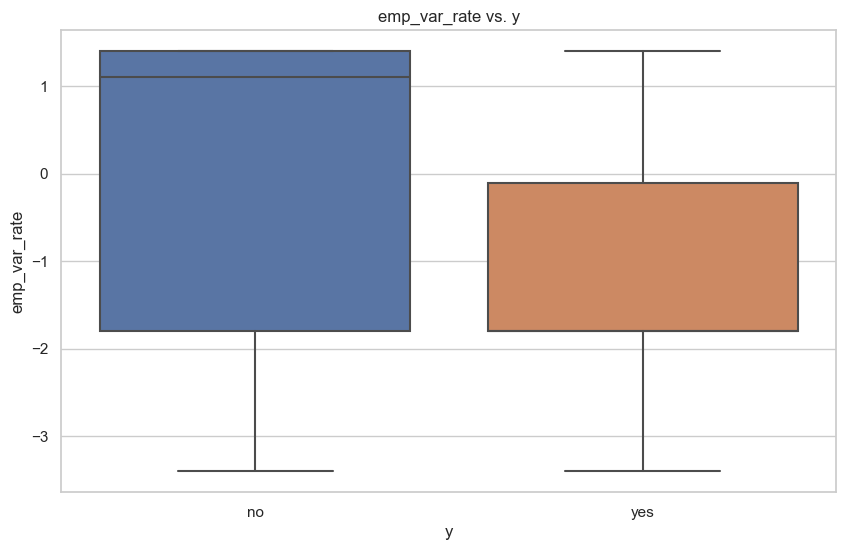

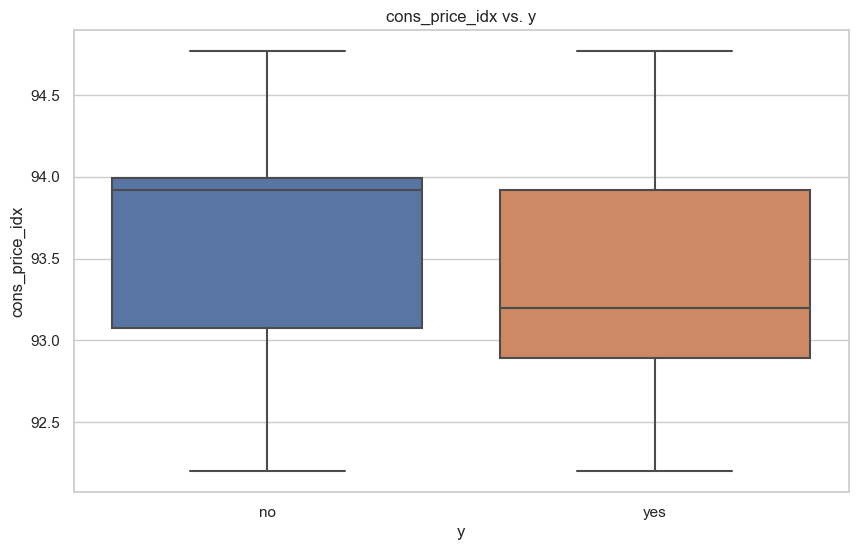

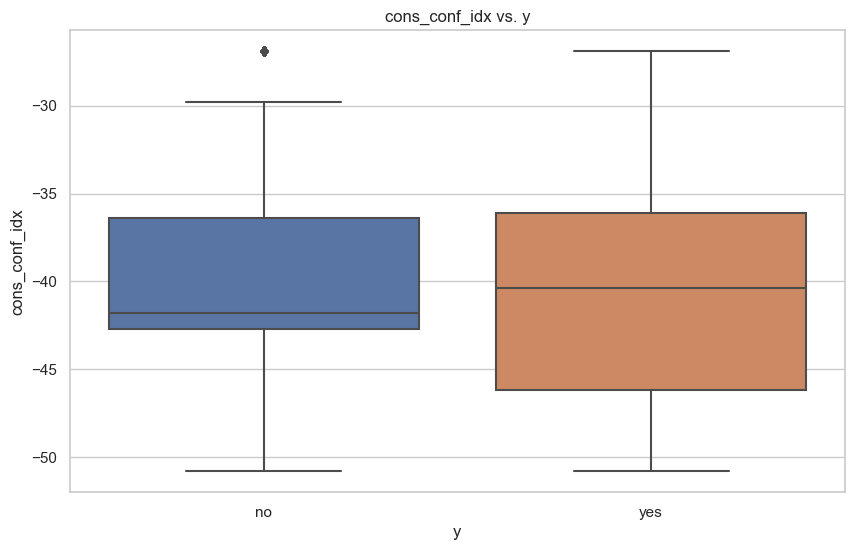

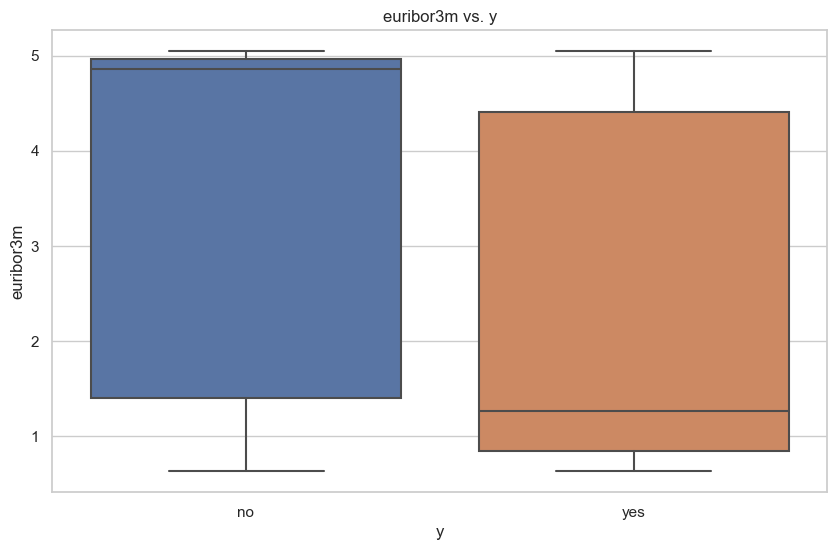

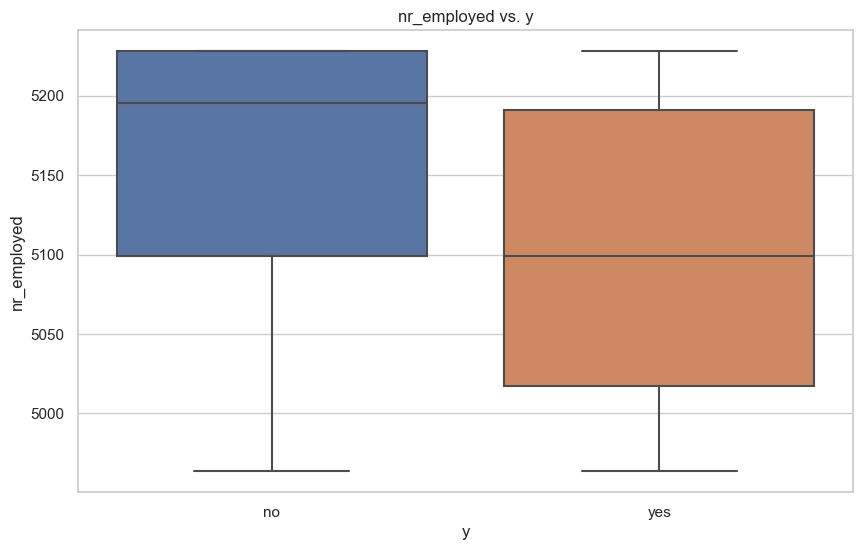

In [9]:
# Include the target_column in numerical_data
numerical_data = data.select([target_column] + numerical_columns).toPandas()

# Bivariate analysis: Box plots for numerical features
for col_name in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=target_column, y=col_name, data=numerical_data)
    plt.title(f'{col_name} vs. {target_column}')
    plt.show()


# Random Forest

In [10]:

#####Random Forest
# Replace dots in column names with underscores
data = data.toDF(*[col.replace('.', '_') for col in data.columns])

# Define categorical and numerical columns
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
numerical_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

# Encode categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column + '_index', handleInvalid='keep') for column in categorical_columns]
encoders = [OneHotEncoder(inputCol=column + '_index', outputCol=column + '_encoded') for column in categorical_columns]

# Label encoding for target column "y"
label_encoder = StringIndexer(inputCol="y", outputCol="label")

# Define the feature columns
feature_columns = ["age"] + [column + '_index' for column in categorical_columns] + numerical_columns

# Create a VectorAssembler to combine feature columns
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a RandomForestClassifier for binary classification
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

# Create a pipeline with the defined stages
pipeline_stages = indexers + encoders + [label_encoder, feature_assembler, rf]
pipeline = Pipeline(stages=pipeline_stages)
training_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Fit the pipeline on the training data
model = pipeline.fit(training_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label")
area_under_curve = evaluator.evaluate(predictions)
print(f"Area Under ROC Curve: {area_under_curve}")


# Print the model summary or relevant information
print("Model Summary:")
print(model.stages[-1])  


Area Under ROC Curve: 0.931251448972968
Model Summary:
RandomForestClassificationModel: uid=RandomForestClassifier_5b1351b95820, numTrees=20, numClasses=2, numFeatures=21


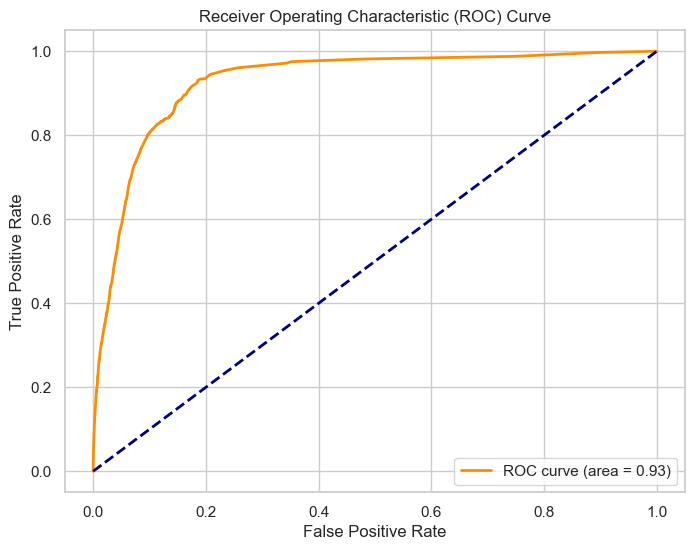

In [12]:
## Random forest 
 

 
# Get the ROC curve
roc = model.stages[-1].summary.roc.toPandas()
fpr, tpr = roc['FPR'], roc['TPR']
 
# Calculate AUC
roc_auc = model.stages[-1].summary.areaUnderROC
 
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# XGBOOST

In [13]:

###XGBOOST

# Replace dots in column names with underscores
data = data.toDF(*[col.replace('.', '_') for col in data.columns])

# Define categorical and numerical columns
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
numerical_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

# Encode categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column + '_index', handleInvalid='keep') for column in categorical_columns]

# Label encoding for target column "y"
label_encoder = StringIndexer(inputCol="y", outputCol="label")

# Define the feature columns
feature_columns = ["age"] + [column + '_index' for column in categorical_columns] + numerical_columns

# Create a VectorAssembler to combine feature columns
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a GBTClassifier for binary classification (XGBoost)
xgboost = GBTClassifier(featuresCol="features", labelCol="label", maxIter=10)

# Create a pipeline with the defined stages
pipeline_stages = indexers + [label_encoder, feature_assembler, xgboost]
pipeline = Pipeline(stages=pipeline_stages)

# Fit the pipeline on the training data
model = pipeline.fit(training_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label")
area_under_curve = evaluator.evaluate(predictions)
print(f"Area Under ROC Curve (XGBoost): {area_under_curve}")

# Print the model summary or relevant information
print("XGBoost Model Summary:")
print(model.stages[-1])  


23/11/29 23:13:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/29 23:13:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Area Under ROC Curve (XGBoost): 0.9463058161186944
XGBoost Model Summary:
GBTClassificationModel: uid = GBTClassifier_61e76017eaec, numTrees=10, numClasses=2, numFeatures=21


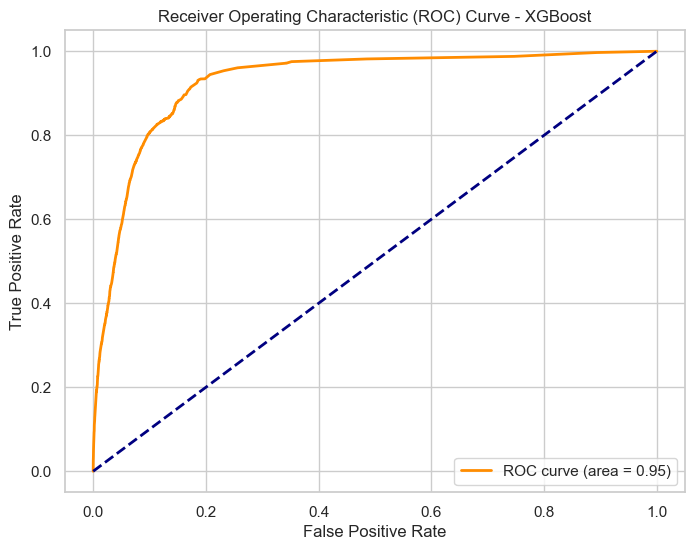

In [14]:
#XG boost 
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
 
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {area_under_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()

In [16]:
xgboost.save("/Users/tharunponnaganti/Downloads/GBTClassifierModelPickleFile2")


In [17]:
#Loading above model

pipelineModel = xgboost.load("/Users/tharunponnaganti/Downloads/GBTClassifierModelPickleFile2")

# Decision Tree

In [18]:
###Decision Tree



from pyspark.ml.classification import DecisionTreeClassifier

# Create a DecisionTreeClassifier for binary classification
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Create a pipeline with the defined stages
pipeline_stages_dt = indexers + encoders + [label_encoder, feature_assembler, dt]
pipeline_dt = Pipeline(stages=pipeline_stages_dt)

# Fit the pipeline on the training data
model_dt = pipeline_dt.fit(training_data)

# Make predictions on the test data
predictions_dt = model_dt.transform(test_data)

# Evaluate the model
evaluator_dt = BinaryClassificationEvaluator(labelCol="label")
area_under_curve_dt = evaluator_dt.evaluate(predictions_dt)
print(f"Area Under ROC Curve (Decision Tree): {area_under_curve_dt}")

# Print the model summary or relevant information
print("Decision Tree Model Summary:")
print(model_dt.stages[-1])  


Area Under ROC Curve (Decision Tree): 0.6703674024257404
Decision Tree Model Summary:
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_aeedcc6a9de4, depth=5, numNodes=37, numClasses=2, numFeatures=21


# Gradient Boosting

In [19]:
###Gradient Boosting

from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Replace dots in column names with underscores
data = data.toDF(*[col.replace('.', '_') for col in data.columns])

# Define categorical and numerical columns
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
numerical_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

# Encode categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column + '_index', handleInvalid='keep') for column in categorical_columns]
encoders = [OneHotEncoder(inputCol=column + '_index', outputCol=column + '_encoded') for column in categorical_columns]

# Label encoding for target column "y"
label_encoder = StringIndexer(inputCol="y", outputCol="label")

# Define the feature columns
feature_columns = ["age"] + [column + '_index' for column in categorical_columns] + numerical_columns

# Create a VectorAssembler to combine feature columns
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a GBTClassifier for binary classification
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=10)

# Create a pipeline with the defined stages
pipeline_stages_gbt = indexers + encoders + [label_encoder, feature_assembler, gbt]
pipeline_gbt = Pipeline(stages=pipeline_stages_gbt)

# Fit the pipeline on the training data
model_gbt = pipeline_gbt.fit(training_data)

# Make predictions on the test data
predictions_gbt = model_gbt.transform(test_data)

# Evaluate the model
evaluator_gbt = BinaryClassificationEvaluator(labelCol="label")
area_under_curve_gbt = evaluator_gbt.evaluate(predictions_gbt)
print(f"Area Under ROC Curve (GBT): {area_under_curve_gbt}")

# Print the model summary or relevant information
print("GBT Model Summary:")
print(model_gbt.stages[-1])  


Area Under ROC Curve (GBT): 0.9462248080299813
GBT Model Summary:
GBTClassificationModel: uid = GBTClassifier_f3498d86f7a6, numTrees=10, numClasses=2, numFeatures=21


# champion model

In [20]:
# Compare AUC values and identify the champion model
champion_model = None
champion_auc = 0.0
 
# XGBoost
if area_under_curve > champion_auc:
    champion_auc = area_under_curve
    champion_model = "XGBoost"
 
# Decision Tree
if area_under_curve_dt > champion_auc:
    champion_auc = area_under_curve_dt
    champion_model = "Decision Tree"
 
# GBT (Gradient Boosting)
if area_under_curve_gbt > champion_auc:
    champion_auc = area_under_curve_gbt
    champion_model = "GBT"
 
# Print the champion model
print(f"\nChampion Model: {champion_model}")
print(f"Area Under ROC Curve (Champion Model): {champion_auc}")


Champion Model: XGBoost
Area Under ROC Curve (Champion Model): 0.9463058161186944


# K-means Clustering is optional

In [21]:

####K-means Clustering is optional

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Select only numeric columns for clustering
numerical_columns_cluster = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

# Create a VectorAssembler to combine feature columns
feature_assembler_cluster = VectorAssembler(inputCols=numerical_columns_cluster, outputCol="features")

# Define the K-means model with the desired number of clusters (k)
kmeans = KMeans(featuresCol="features", k=3, seed=42)

# Create a pipeline with the defined stages for clustering
pipeline_stages_cluster = [feature_assembler_cluster, kmeans]
pipeline_cluster = Pipeline(stages=pipeline_stages_cluster)

# Fit the pipeline on the data
model_cluster = pipeline_cluster.fit(data)

# Make predictions on the data to get cluster assignments
clustered_data = model_cluster.transform(data)

# Show the cluster assignments for each record
clustered_data.select("features", "prediction").show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[56.0,261.0,1.0,9...|         0|
|[57.0,149.0,1.0,9...|         0|
|[37.0,226.0,1.0,9...|         0|
|[40.0,151.0,1.0,9...|         0|
|[56.0,307.0,1.0,9...|         0|
|[45.0,198.0,1.0,9...|         0|
|[59.0,139.0,1.0,9...|         0|
|[41.0,217.0,1.0,9...|         0|
|[24.0,380.0,1.0,9...|         0|
|[25.0,50.0,1.0,99...|         0|
|[41.0,55.0,1.0,99...|         0|
|[25.0,222.0,1.0,9...|         0|
|[29.0,137.0,1.0,9...|         0|
|[57.0,293.0,1.0,9...|         0|
|[35.0,146.0,1.0,9...|         0|
|[54.0,174.0,1.0,9...|         0|
|[35.0,312.0,1.0,9...|         0|
|[46.0,440.0,1.0,9...|         0|
|[50.0,353.0,1.0,9...|         0|
|[39.0,195.0,1.0,9...|         0|
+--------------------+----------+
only showing top 20 rows



In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("XYZ Bank Deposit Classification") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()


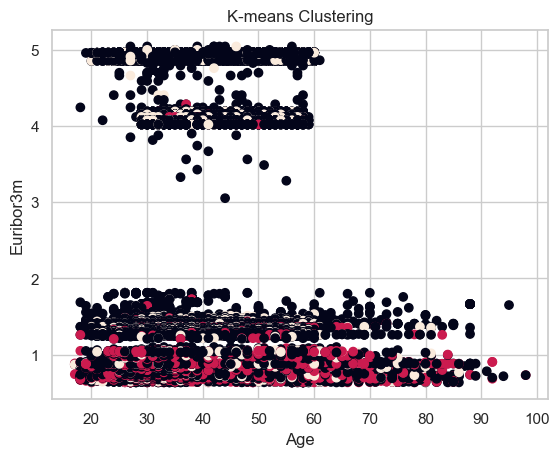

In [22]:
import matplotlib.pyplot as plt

# Extract the PCA features for plotting
pandas_df = clustered_data.toPandas()  # Convert Spark DataFrame to Pandas DataFrame

# Plotting
plt.scatter(pandas_df['age'], pandas_df['euribor3m'], c=pandas_df['prediction'])
plt.title("K-means Clustering")
plt.xlabel("Age")
plt.ylabel("Euribor3m")
plt.show()
# Stop the Spark session
#spark.stop()

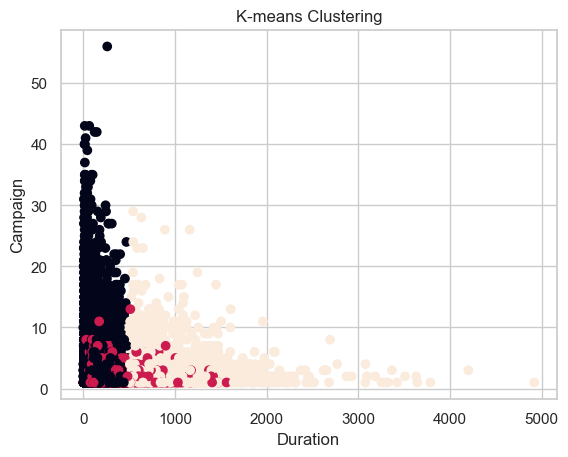

In [25]:
# Plotting with 'duration' and 'campaign'
plt.scatter(pandas_df['duration'], pandas_df['campaign'], c=pandas_df['prediction'])
plt.title("K-means Clustering")
plt.xlabel("Duration")
plt.ylabel("Campaign")
plt.show()

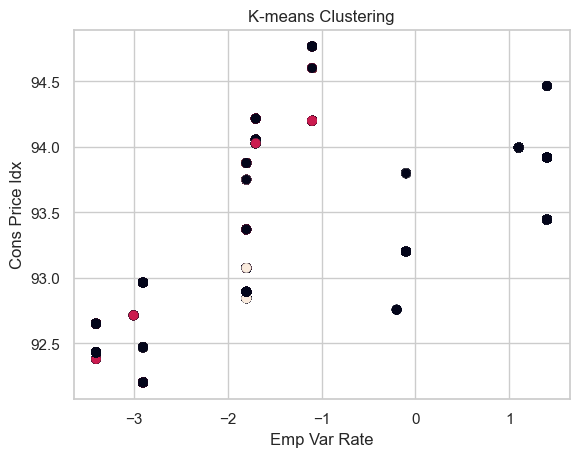

In [26]:
plt.scatter(pandas_df['emp_var_rate'], pandas_df['cons_price_idx'], c=pandas_df['prediction'])
plt.title("K-means Clustering")
plt.xlabel("Emp Var Rate")
plt.ylabel("Cons Price Idx")
plt.show()

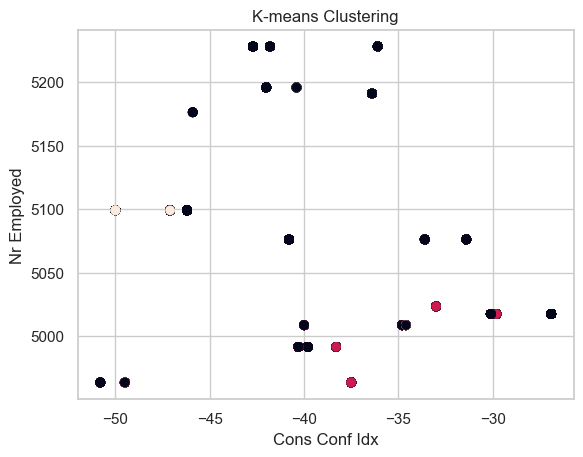

In [27]:
plt.scatter(pandas_df['cons_conf_idx'], pandas_df['nr_employed'], c=pandas_df['prediction'])
plt.title("K-means Clustering")
plt.xlabel("Cons Conf Idx")
plt.ylabel("Nr Employed")
plt.show()